In [29]:
import numpy as np
import pandas as pd


### Exercise 2

### 2.1

In [33]:
def sup(D, X, Y=None):
    supp = 0
    if Y is None:
        for transaction in D:
            if all(item in transaction for item in X):
                supp += 1
    else:
        for transaction in D:
            if all(item in transaction for item in X) and all(item in transaction for item in Y):
                supp += 1
    return supp

def conf(D, X, Y):
    return sup(D, X, Y) / sup(D, X)

def lift(D, X, Y=None):
    if Y is None:
        Y = X.copy()
    supports = [sum(all(item in transaction for item in items) for transaction in D) for items in (X, Y, X + Y)]
    if 0 in (r_support := [sup / len(D) for sup in supports]):
        return None
    return r_support[2] / (r_support[0] * r_support[1])

def leverage(D, X, Y):
    supports = [sum(all(item in transaction for item in items) for transaction in D) for items in (X, Y, X + Y)]
    final_leverage = supports[2] / len(D) - (supports[0] / len(D)) * (supports[1] / len(D))
    return final_leverage

def jaccard(D, X, Y):
    return sup(D, X, Y) / (sup(D, X) + sup(D, Y) - sup(D, X, Y))

def conviction(D, X, Y):
    support_y = sum(all(item in transaction for item in Y) for transaction in D) / len(D)
    confidence_xy = conf(D, X, Y)
    if confidence_xy >= 1:
        return None
    return (1 - support_y) / (1 - confidence_xy)

def oddsRatio(D, X, Y):
    supports = {(False, False): 0, (False, True): 0, (True, False): 0, (True, True): 0}
    for transaction in D:
        supports[(all(item in transaction for item in X), all(item in transaction for item in Y))] += 1
    final_odds_ratio = ((supports[(True, True)] + 1) * (supports[(False, False)] + 1)) / ((supports[(False, True)] + 1) * (supports[(True, False)] + 1))
    return final_odds_ratio

def imp(D, X, Y):
    conf_XY = conf(D, X, Y)  # Confianza de la regla X → Y
    WConfidence = []
    for W in X:
        conf_WY = conf(D, [W], Y)
        WConfidence.append(conf_WY)
    # Calculamos la mejora como la diferencia entre la confianza de la regla X → Y y la máxima confianza entre X y Y
    improvement = conf_XY - max(WConfidence)
    return improvement

def getRuleMetric(D,X,Y,metric):
    if metric == "sup":
        return sup(D,X,Y)
    elif metric == "conf":
        return conf(D,X,Y)
    elif metric == "lift":
        return lift(D,X,Y)
    elif metric == "leverage":
        return leverage(D,X,Y)
    elif metric == "jaccard":
        return jaccard(D,X,Y)
    elif metric == "conviction":
        return conviction(D,X,Y)
    elif metric == "oddsratio":
        return oddsRatio(D,X,Y)
    elif metric == "imp":
        return imp(D,X,Y)
    else:
        return "metrica invalida"
    


### 2.2

In [37]:
def filterProductiveRules(D, R):
    productive_rules = []
    for rule in R:
        X, Y, sup_XY, conf_XY = rule
        improvement = imp(D, X, Y)
        if improvement > 0:
            productive_rules.append(rule)
    return productive_rules

### 2.3

In [38]:
from templateobs import *
D = read_database("shop.dat")
R = getStrongRules(D, 500, 0.95)
dfR = pd.DataFrame(R, columns=['X', 'Y', 'sup', 'conf']) 
display(dfR)
print("Filtered Rules")
RFiltered = filterProductiveRules(D, R)
dfRfiltered = pd.DataFrame(RFiltered, columns=['X', 'Y', 'sup', 'conf']) 
display(dfRfiltered)



X      Y  sup      conf
0     [12, 227, 390]  [722]  578  0.952224
1    [413, 793, 857]   [21]  664  0.960926
2     [21, 793, 857]  [413]  664  0.955396
3     [21, 413, 857]  [793]  664  0.965116
4          [21, 857]  [793]  695  0.953361
..               ...    ...  ...       ...
171       [546, 923]  [947]  584  0.973333
172  [572, 579, 842]  [803]  531  0.951613
173       [579, 842]  [803]  570  0.950000
174       [708, 978]  [883]  542  0.952548
175            [969]  [888]  810  0.954064

[176 rows x 4 columns]

Filtered Rules


X      Y  sup      conf
0     [12, 227, 390]  [722]  578  0.952224
1    [413, 793, 857]   [21]  664  0.960926
2     [21, 793, 857]  [413]  664  0.955396
3     [21, 413, 857]  [793]  664  0.965116
4          [21, 857]  [793]  695  0.953361
..               ...    ...  ...       ...
130       [546, 947]  [661]  592  0.973684
131       [546, 661]  [947]  592  0.970492
132       [546, 947]  [923]  584  0.960526
133       [546, 923]  [947]  584  0.973333
134       [708, 978]  [883]  542  0.952548

[135 rows x 4 columns]

In [43]:
dfRfiltered['rule_id'] = range(1, len(dfRfiltered) + 1)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

# Supongamos que tienes un DataFrame 'df' con tus datos

for index, row in dfRfiltered.iterrows():
    X, Y = row['X'], row['Y']
    # Calcula y agrega las métricas para cada regla
    for metric in ["sup", "conf", "lift", "leverage", "jaccard", "conviction", "oddsratio", "imp"]:
        metric_value = getRuleMetric(D, X, Y, metric)
        # Agrega el valor de la métrica como una nueva columna en el DataFrame dfRfiltered
        dfRfiltered.at[index, metric] = metric_value

display(dfRfiltered)# Paso 2: Crear combinaciones de métricas por su label
metric_combinations = dfRfiltered[['sup', 'conf', 'lift', 'leverage', 'jaccard', 'conviction', 'oddsratio', 'imp']]




X      Y  sup      conf  rule_id       lift  leverage  \
0     [12, 227, 390]  [722]  578  0.952224        1  16.291258  0.005425   
1    [413, 793, 857]   [21]  664  0.960926        2  36.043743  0.006456   
2     [21, 793, 857]  [413]  664  0.955396        3  36.230401  0.006457   
3     [21, 413, 857]  [793]  664  0.965116        4  31.508857  0.006429   
4          [21, 857]  [793]  695  0.953361        5  31.125066  0.006727   
..               ...    ...  ...       ...      ...        ...       ...   
130       [546, 947]  [661]  592  0.973684      131  36.156116  0.005756   
131       [546, 661]  [947]  592  0.970492      132  26.300591  0.005695   
132       [546, 947]  [923]  584  0.960526      133  54.793287  0.005733   
133       [546, 923]  [947]  584  0.973333      134  26.377597  0.005619   
134       [708, 978]  [883]  542  0.952548      135  19.431830  0.005141   

      jaccard  conviction    oddsratio       imp  
0    0.098400   19.707616   344.846450  0.404919  
1    0.246565   24.910294  1153.801797  0.501858  
2    0.248876   21.828156  1024.671432  0.495068  
3    0.215096   27.788607  1074.130167  0.502900  
4    0.224411   20.784433   813.425605  0.491144  
..        ...         ...          ...       ...  
130  0.218531   36.976660  1614.545139  0.392732  
131  0.159655   32.638389   969.782256  0.391444  
132  0.328644   24.889240  1964.480000  0.389098  
133  0.157582   36.116250  1066.521044  0.394286  
134  0.109961   20.041023   422.774069  0.393833  

[135 rows x 11 columns]

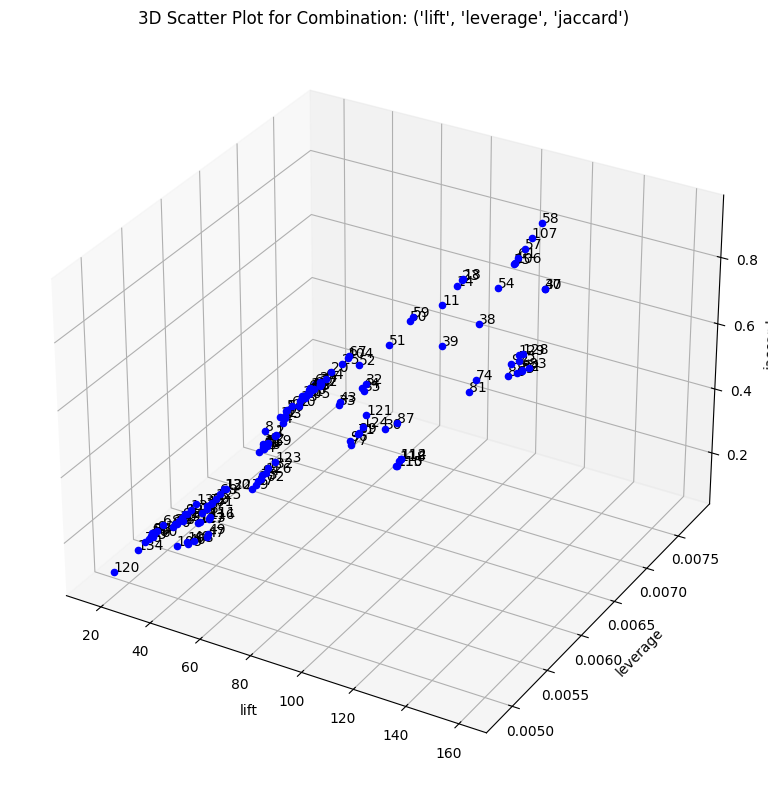

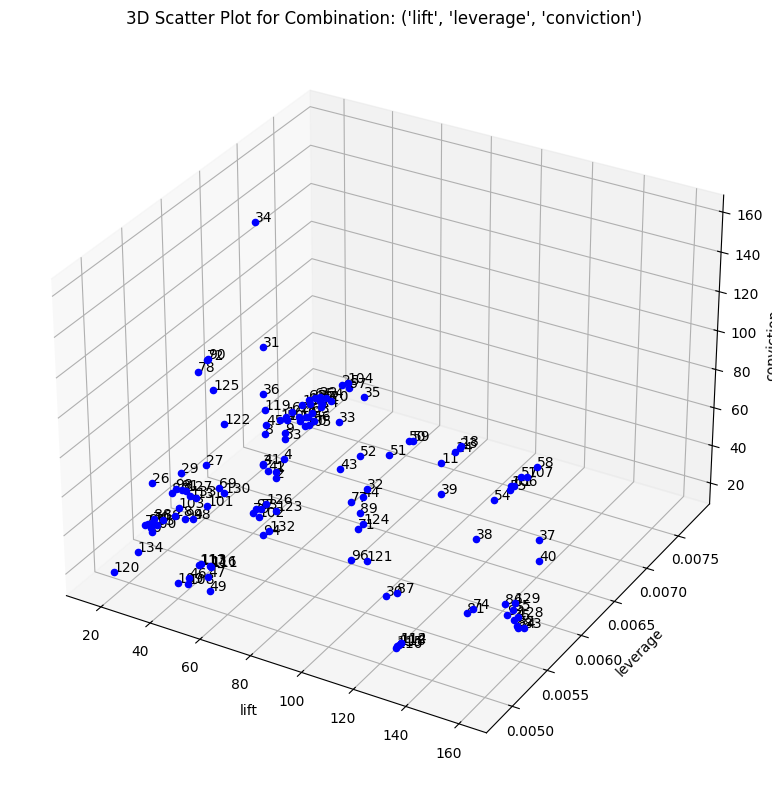

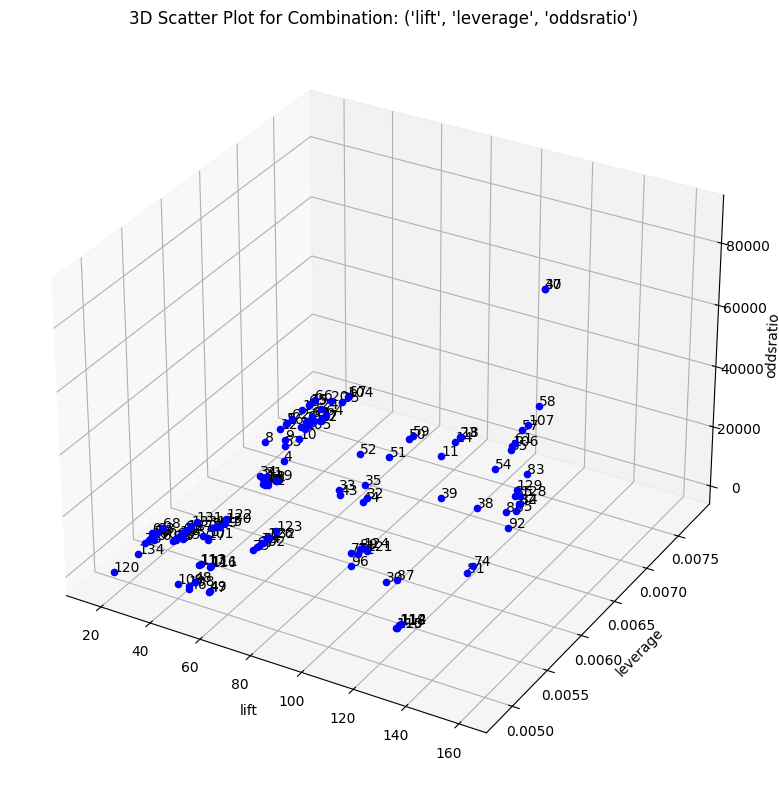

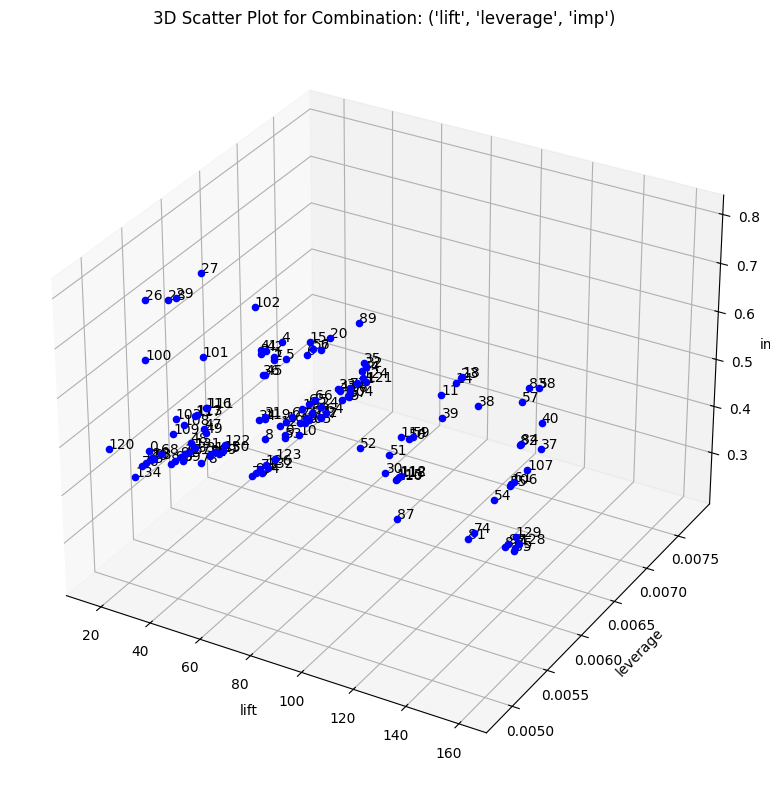

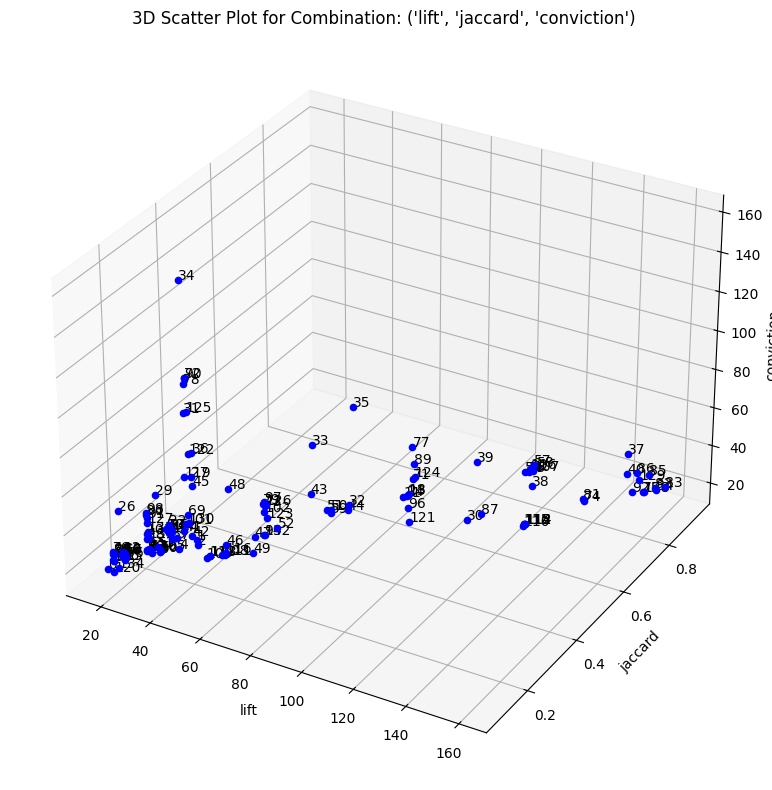

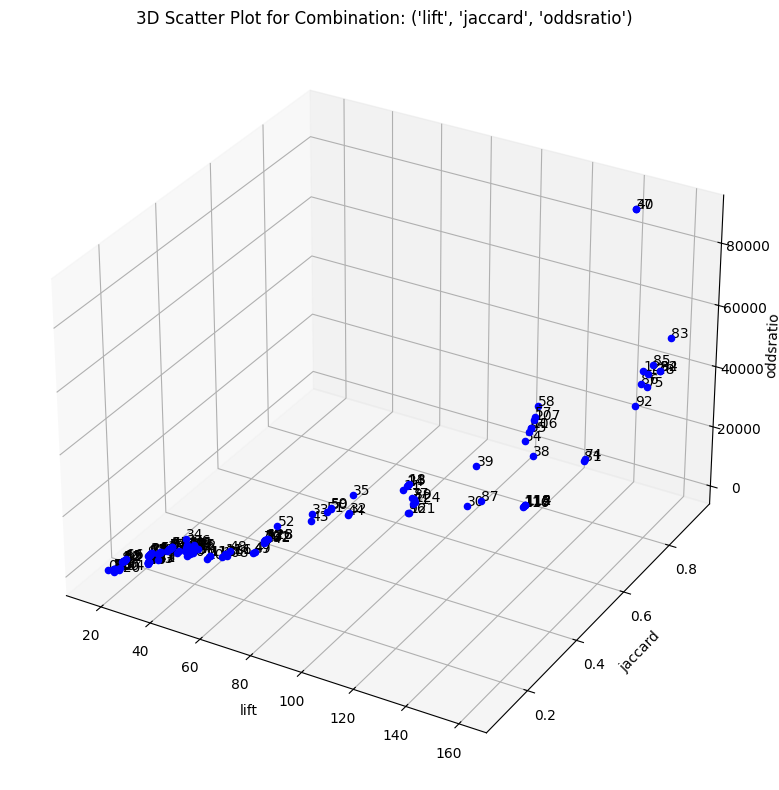

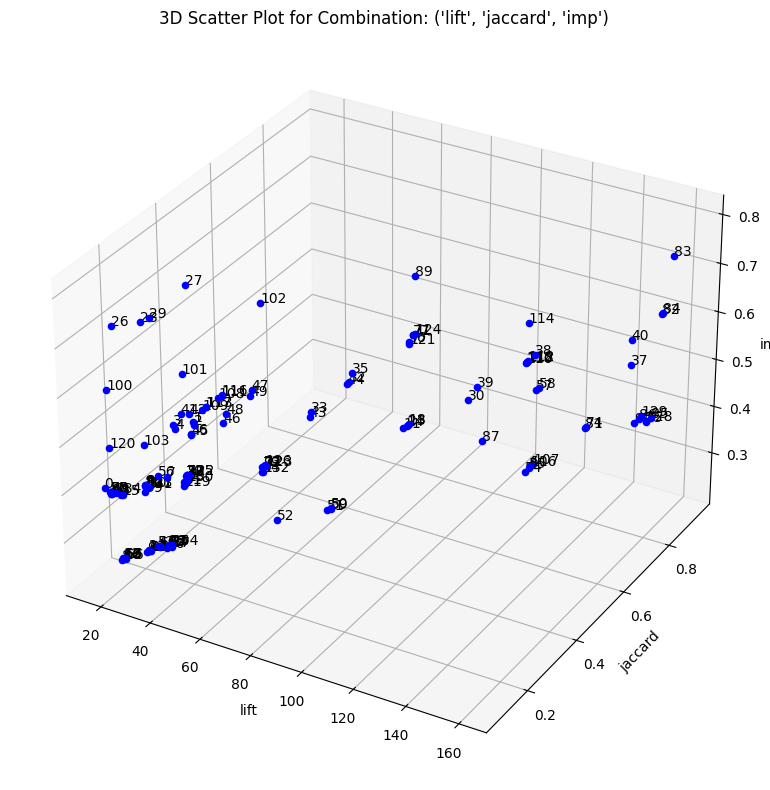

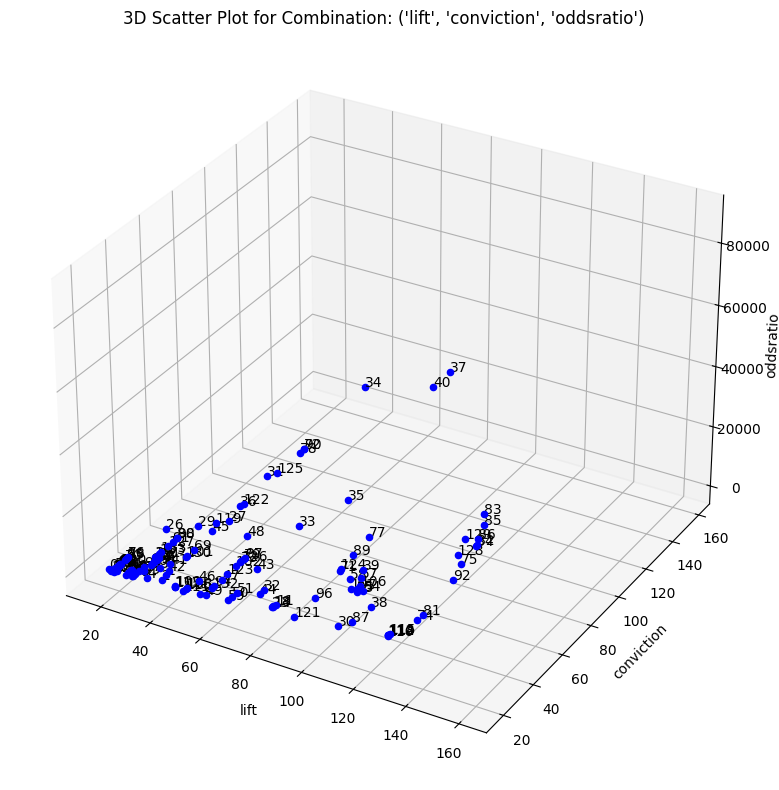

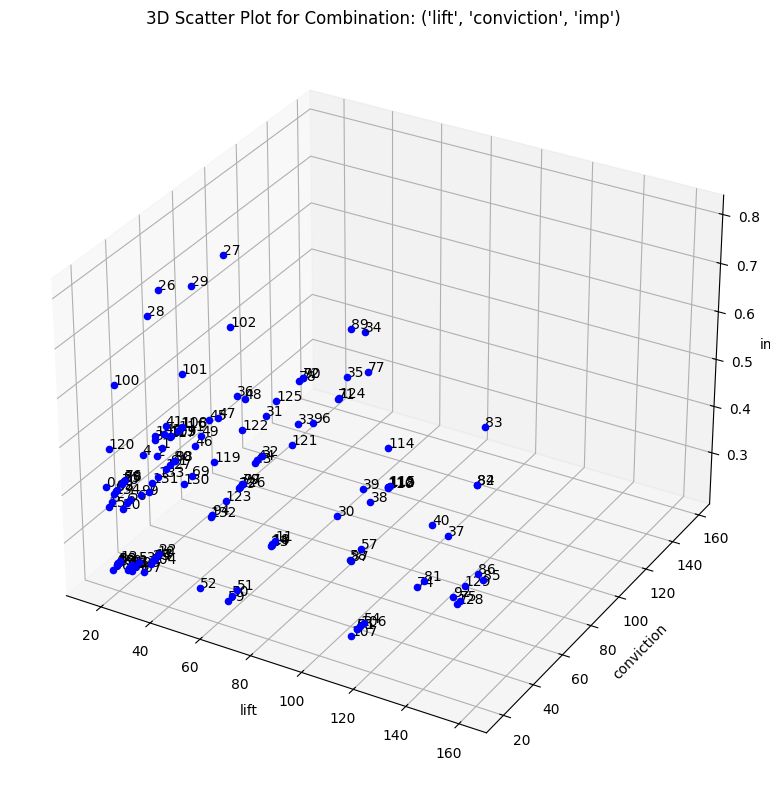

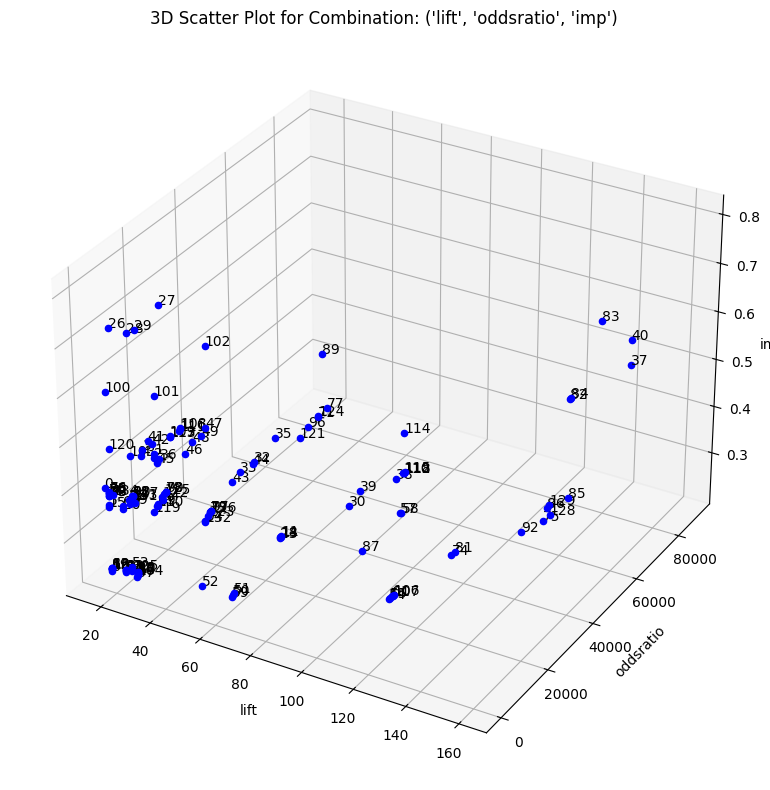

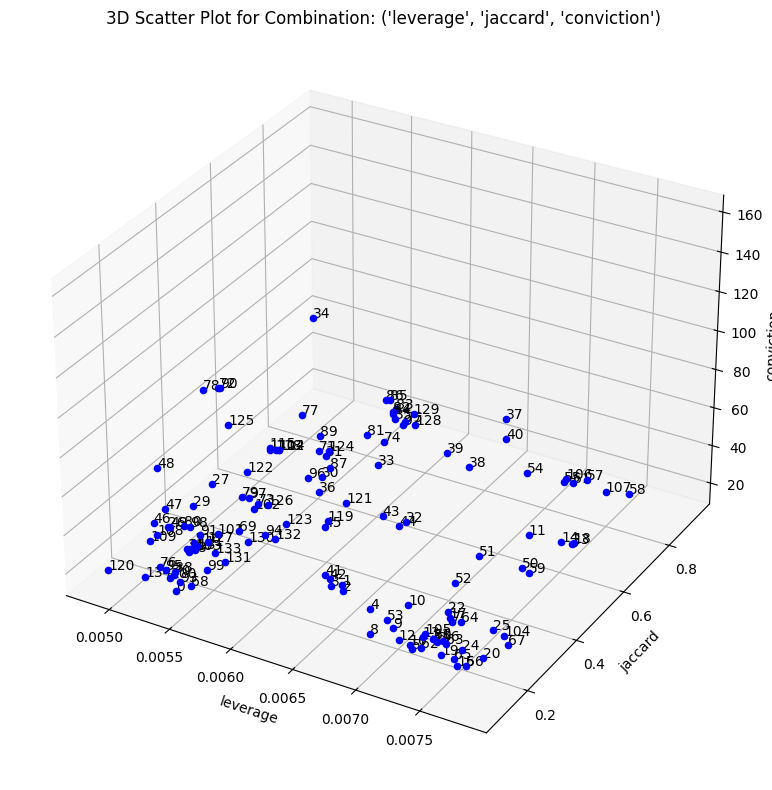

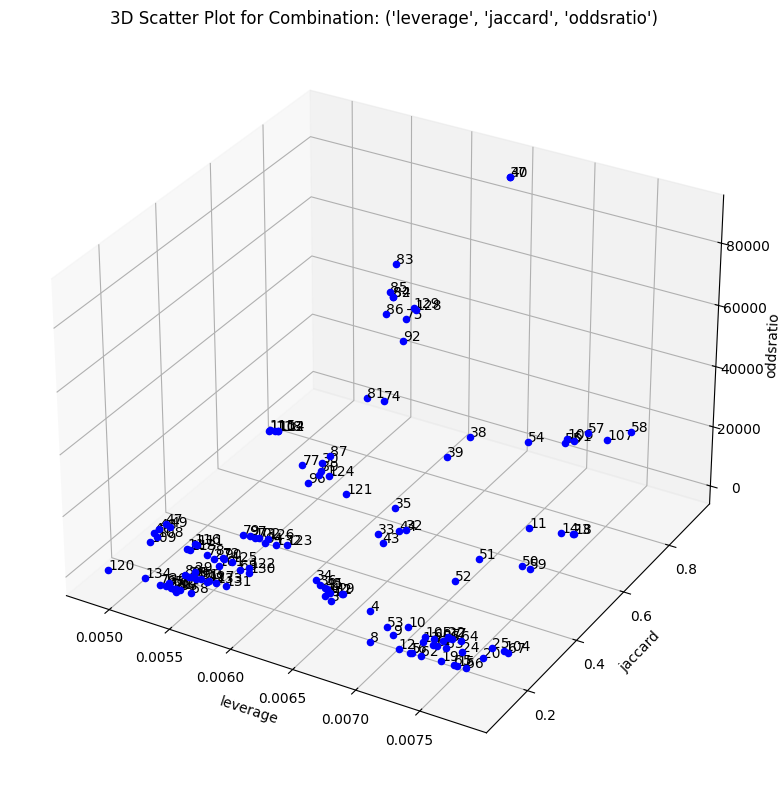

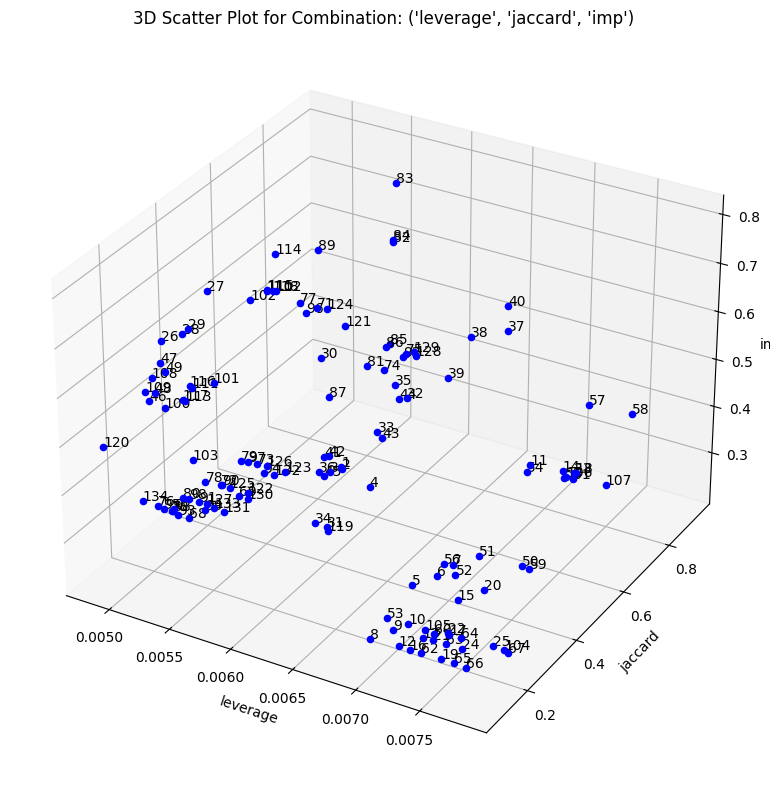

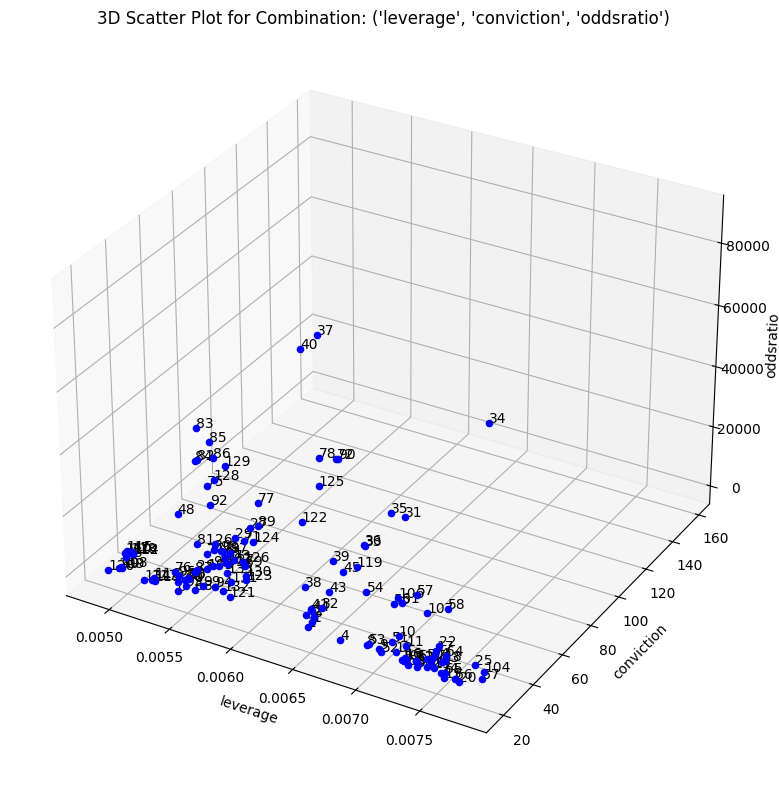

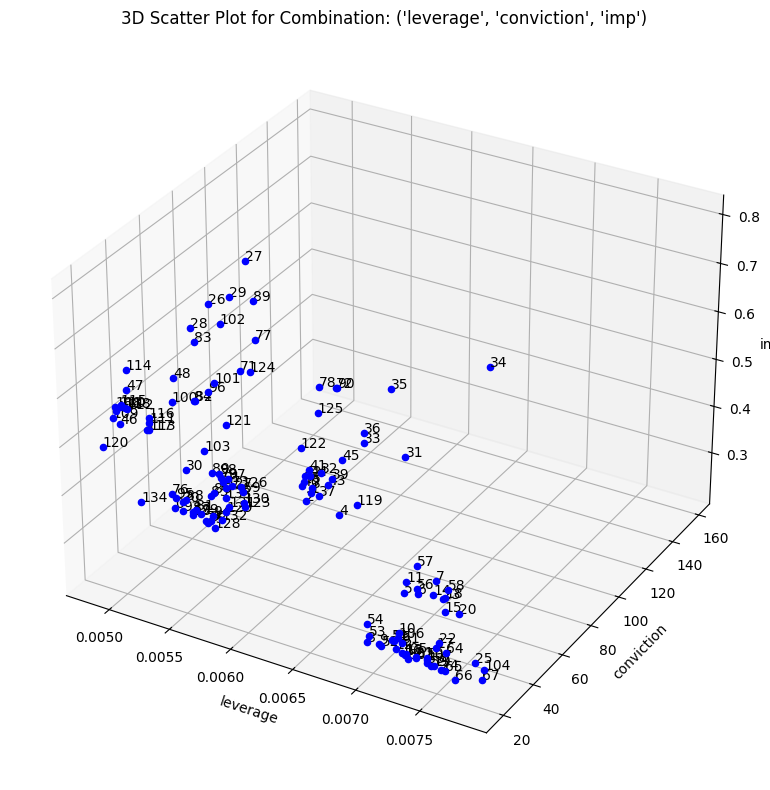

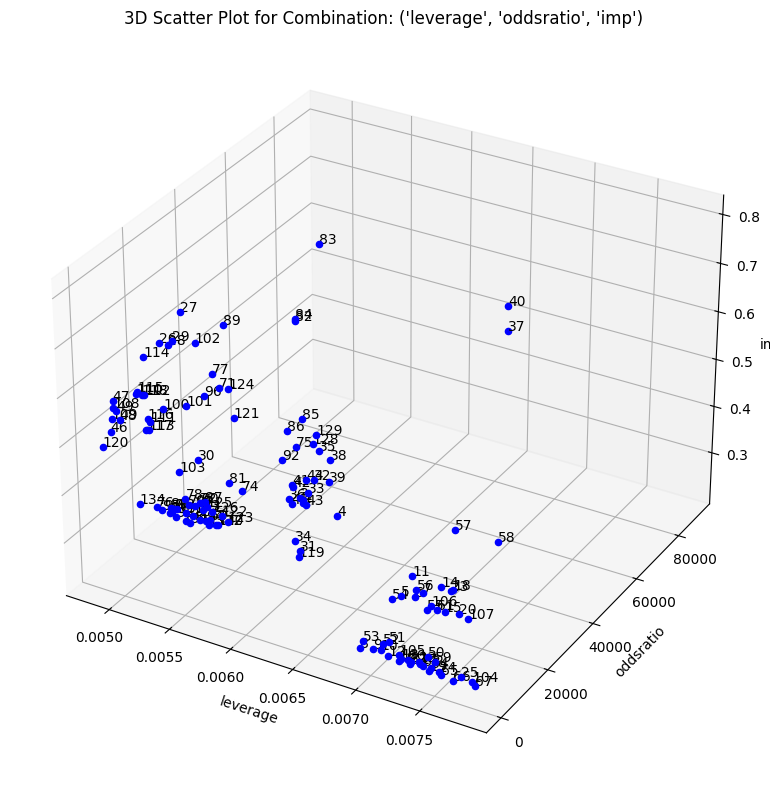

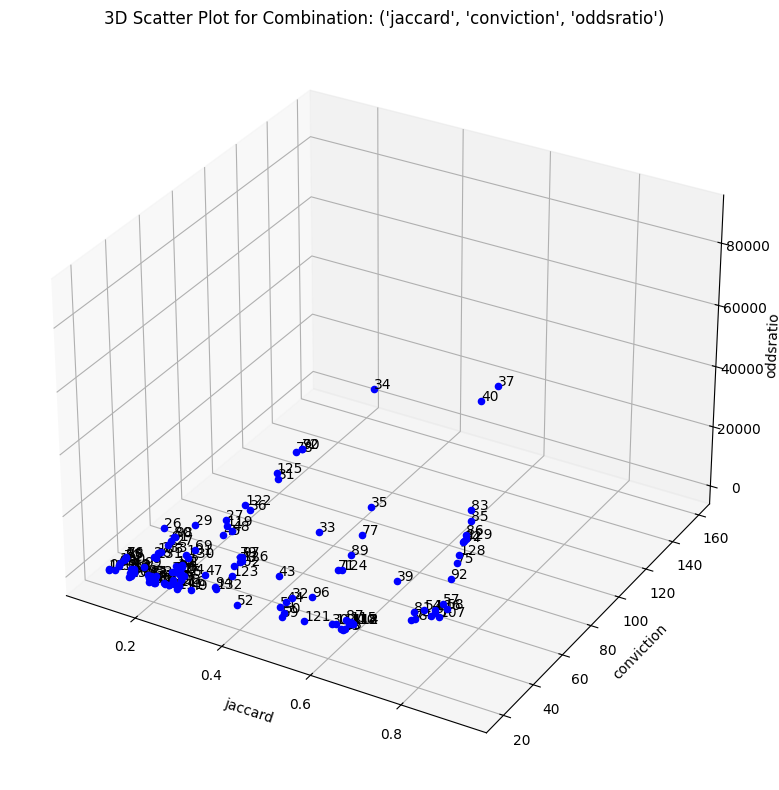

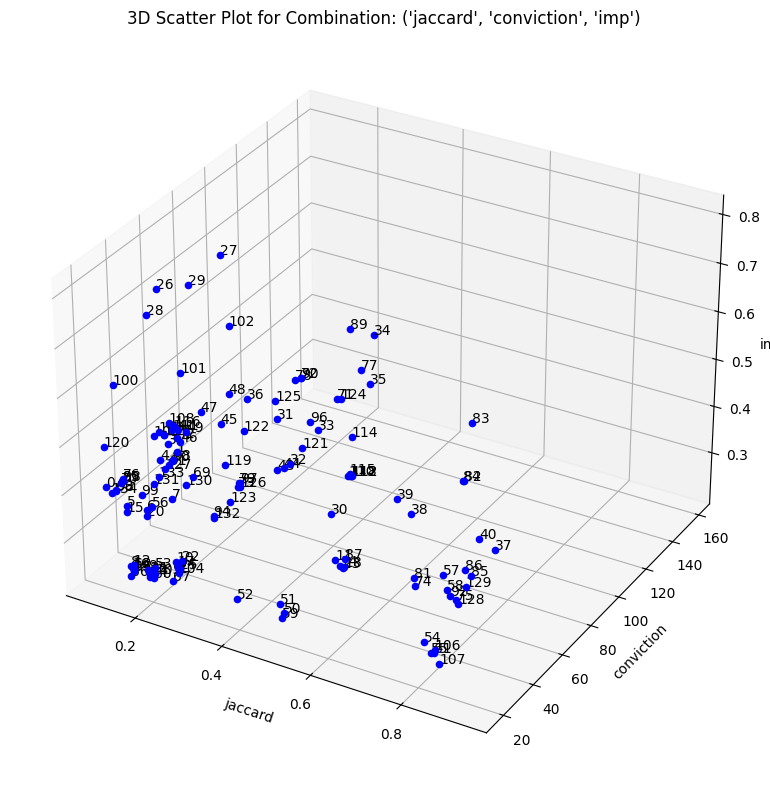

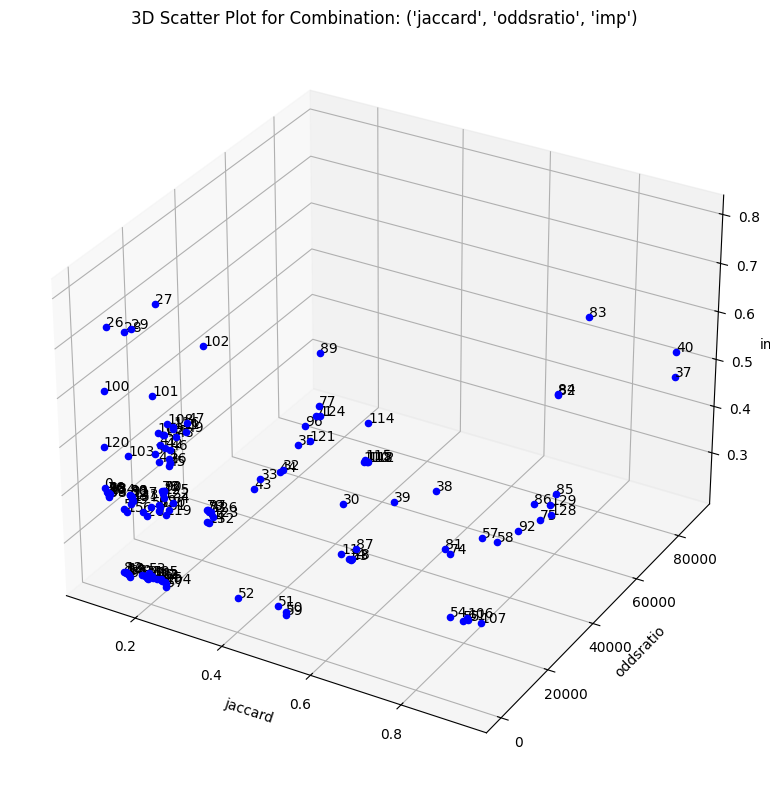

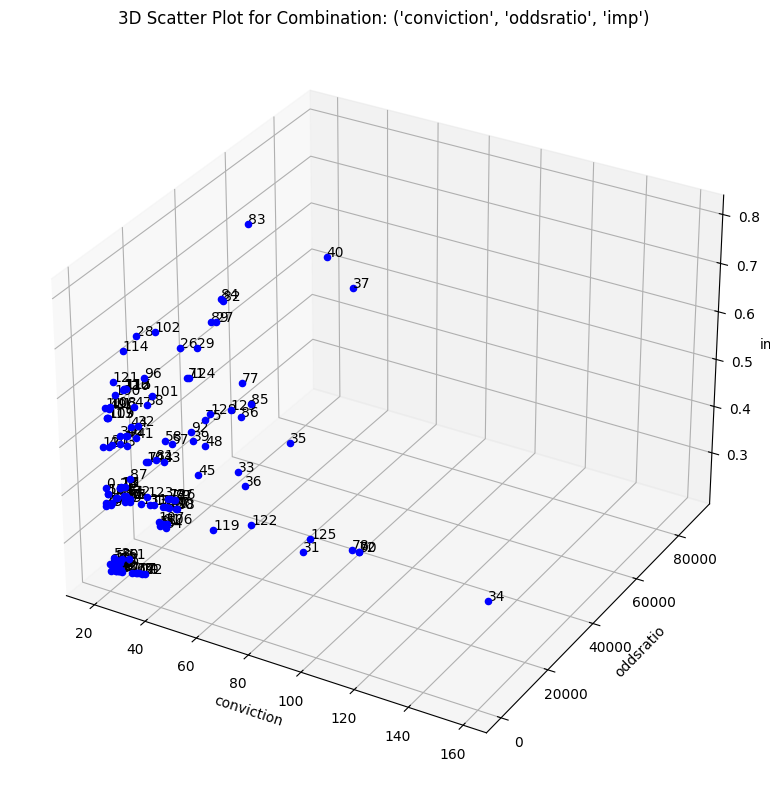

In [53]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

metric_combinations = itertools.combinations(["lift", "leverage", "jaccard", "conviction", "oddsratio", "imp"], 3)


for combination in metric_combinations:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(combination[0])
    ax.set_ylabel(combination[1])
    ax.set_zlabel(combination[2])
    ax.set_title(f"3D Scatter Plot for Combination: {combination}")

    for index, row in dfRfiltered.iterrows():
        X, Y = row['X'], row['Y']
        
        x_value = getRuleMetric(D, X, Y, combination[0])
        y_value = getRuleMetric(D, X, Y, combination[1])
        z_value = getRuleMetric(D, X, Y, combination[2])
        
        ax.scatter(x_value, y_value, z_value, color='b')

        ax.text(x_value, y_value, z_value, f"{index}", color='black')

    plt.tight_layout()
    plt.show()
